# Определение стоимости автомобилей

_____
**Описание исследования.**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
_____
**Цель исследования.**

Разработка системы рекомендации стоимости автомобиля на основе его описания
_____
**Исходные данные.**
    
Признаки

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя


Целевой признак
- `Price` — цена (евро)

______



## Подготовка данных

In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (
   OneHotEncoder,
   OrdinalEncoder,
   StandardScaler
)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error
import time
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import  make_pipeline
from catboost import CatBoostRegressor, cv, train
from lightgbm import LGBMRegressor


#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


# настройки
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
df.shape

(354369, 16)

In [4]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
137279,2016-03-23 22:40:35,1400,sedan,1995,auto,125,a4,150000,3,petrol,audi,no,2016-03-23 00:00:00,0,74080,2016-04-06 03:46:47
243133,2016-03-19 07:56:16,11490,convertible,2006,auto,174,cooper,40000,12,petrol,mini,no,2016-03-19 00:00:00,0,80992,2016-04-02 06:45:49
159010,2016-03-22 21:57:58,6500,sedan,2007,manual,143,1er,150000,12,gasoline,bmw,no,2016-03-22 00:00:00,0,47638,2016-03-31 23:45:38
81204,2016-03-17 17:52:43,3000,coupe,2006,manual,0,other,150000,4,lpg,fiat,NaN,2016-03-17 00:00:00,0,88131,2016-03-28 21:46:59
247029,2016-03-12 16:52:03,2350,small,2002,manual,75,clio,150000,2,petrol,renault,no,2016-03-12 00:00:00,0,88299,2016-04-07 07:17:30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


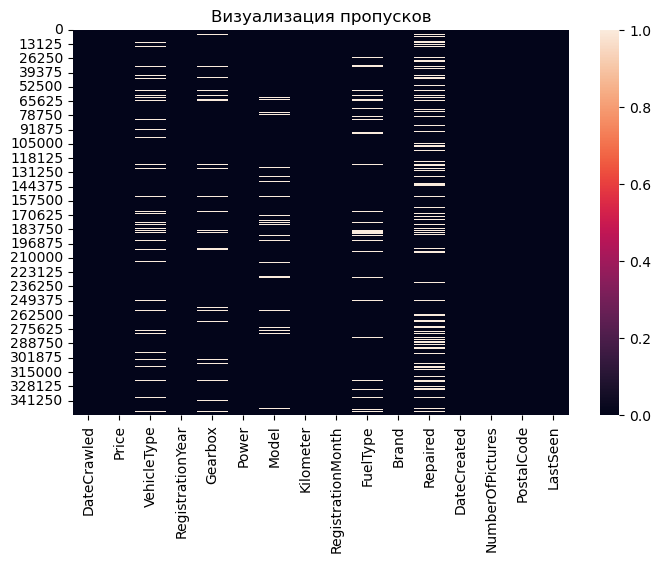

In [7]:
sns.heatmap(df.isnull()) 
plt.title('Визуализация пропусков')
plt.show()

у нас есть пропуски в 5 столбцах: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`.
Прежде чем приступить к работе с пропусками, переименуеи наши столбцы для удобства.

In [8]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [9]:
df.columns = map(str.lower, df.columns)

In [10]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [11]:
df = df.rename(columns =
          {
            'datecrawled':'date_crawled',
            'vehicletype':'vehicle_type', 
            'registrationyear':'registration_year', 
            'registrationmonth':'registration_month', 
            'fueltype':'fuel_type',
            'datecreated':'date_created',
            'numberofpictures':'number_of_pictures',
            'postalcode':'postal_code',
            'lastseen' :'last_seen'
          })

In [12]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [13]:
#выявим явные дубликаты и удалим их
df.duplicated().sum()

4

In [14]:
df = df.drop_duplicates()

In [15]:
df.duplicated().sum()

0

In [16]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Мв столбце `price` минимальное значение равно нулю. странно так, как-будто кто-то забыл написат цену продажи. Хотя как такое можно забыть.  

In [17]:
#Посмотрим где у нас еще по нулям
(df == 0).sum()

date_crawled               0
price                  10772
vehicle_type               0
registration_year          0
gearbox                    0
power                  40225
model                      0
kilometer                  0
registration_month     37352
fuel_type                  0
brand                      0
repaired                   0
date_created               0
number_of_pictures    354365
postal_code                0
last_seen                  0
dtype: int64

In [18]:
#Я, кажется, нашла самый бесполезный столбец. 
df['number_of_pictures'].unique()

array([0], dtype=int64)

Можно предположить, что это пропущенные значения, где неизвестное значение было заменено нулем. Преобразуем все нули в значениях `price`, `power`, на значения NaN и еще раз посчитаем их количество, предварительно сделав копию нашего датасета.

а столбцы `number_of_pictures`, `postal_code`, `date_crawled`, `date_created`, `last_seen`, `model`, `registration_month` давайте удалим. 
- 1 все столбцы у нас по нулям;
- почтовый индекс владельца анкеты не несент в себе никакой инфформации;
- дата скачивания анкеты из базы тоже бесполезна;
- дата создания анкеты тоже;
- дата последней активности пользователя тем более;
- модель автомобиля - тут легче все это дело удалить, чем пытаться понять логику восстановления пропусков;
- месяц регистрации автомобиля.

In [19]:
df.drop(
    ['number_of_pictures', 'postal_code', 'date_crawled', 'date_created', 'last_seen', 'model', 'registration_month'],
    axis=1, inplace=True)

In [20]:
df.shape

(354365, 9)

In [21]:
#проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   kilometer          354365 non-null  int64 
 6   fuel_type          321470 non-null  object
 7   brand              354365 non-null  object
 8   repaired           283211 non-null  object
dtypes: int64(4), object(5)
memory usage: 27.0+ MB


In [22]:
new_data = df.copy(deep = True)
colsFix = ['price','power']
new_data [colsFix] = new_data[colsFix].replace(0, np.NaN)
pd.DataFrame(round(new_data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
price,3.000000
vehicle_type,11.000000
registration_year,0.000000
gearbox,6.000000
power,11.000000
kilometer,0.000000
fuel_type,9.000000
brand,0.000000
repaired,20.000000


ситуация стала как-будто страшнее, но и мы не трусихи...

In [23]:
new_data.describe()

,price,registration_year,power,kilometer
count,343593.000000,354365.000000,314140.000000,354365.000000
mean,4555.147363,2004.234481,124.191109,128211.363989
std,4515.076200,90.228466,197.251312,37905.083858
min,1.000000,1000.000000,1.000000,5000.000000
25%,1200.000000,1999.000000,75.000000,125000.000000
50%,2890.000000,2003.000000,110.000000,150000.000000
75%,6500.000000,2008.000000,150.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [24]:
new_data.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
0,480.0,NaN,1993,manual,NaN,150000,petrol,volkswagen,NaN
1,18300.0,coupe,2011,manual,190.0,125000,gasoline,audi,yes
2,9800.0,suv,2004,auto,163.0,125000,gasoline,jeep,NaN
3,1500.0,small,2001,manual,75.0,150000,petrol,volkswagen,no
4,3600.0,small,2008,manual,69.0,90000,gasoline,skoda,no


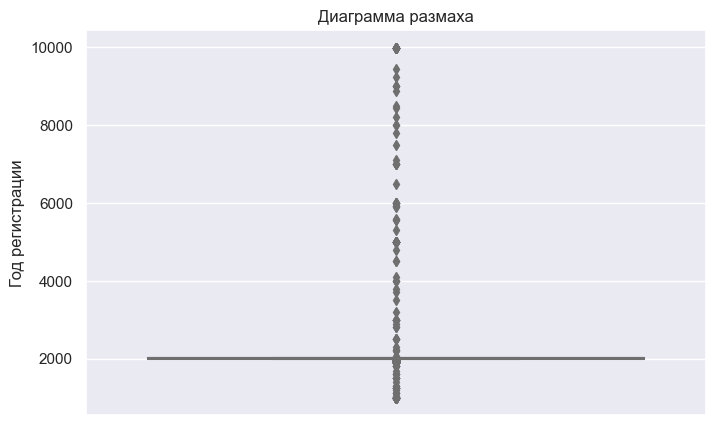

In [25]:
#посмотрим выбросы в столбце registration_year
sns.set(style="darkgrid")
sns.boxplot(y=new_data['registration_year'], color='skyblue')
plt.title('Диаграмма размаха')
plt.ylabel('Год регистрации')

plt.show()

предлагаю не жалеть все что больше 2020 года и меньше 1960. 

In [26]:
new_data.query('registration_year > 2020')

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
12946,49.0,NaN,5000,NaN,NaN,5000,NaN,volkswagen,NaN
15147,NaN,NaN,9999,NaN,NaN,10000,NaN,sonstige_autos,NaN
15870,1700.0,NaN,3200,NaN,NaN,5000,NaN,sonstige_autos,NaN
17271,700.0,NaN,9999,NaN,NaN,10000,NaN,opel,NaN
17346,6500.0,NaN,8888,NaN,NaN,10000,NaN,sonstige_autos,NaN
...,...,...,...,...,...,...,...,...,...
334967,12000.0,NaN,4000,NaN,500.0,5000,NaN,volkswagen,no
335727,NaN,NaN,7500,manual,NaN,10000,petrol,mini,no
338829,50.0,NaN,3000,NaN,3000.0,100000,NaN,volkswagen,yes
340548,NaN,NaN,3500,manual,75.0,5000,petrol,sonstige_autos,NaN


In [27]:
new_data.query('registration_year < 1960')

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
15,450.0,small,1910,NaN,NaN,5000,petrol,ford,NaN
622,NaN,NaN,1111,NaN,NaN,5000,NaN,opel,NaN
1928,7000.0,suv,1945,manual,48.0,150000,petrol,volkswagen,no
2273,1800.0,convertible,1925,NaN,NaN,5000,NaN,sonstige_autos,no
3333,10500.0,sedan,1955,manual,30.0,60000,petrol,ford,NaN
...,...,...,...,...,...,...,...,...,...
351299,5500.0,bus,1956,manual,37.0,60000,petrol,sonstige_autos,no
351682,11500.0,NaN,1800,NaN,16.0,5000,petrol,fiat,NaN
353531,6000.0,sedan,1937,manual,38.0,5000,petrol,mercedes_benz,NaN
353961,200.0,NaN,1910,NaN,NaN,5000,petrol,sonstige_autos,NaN


In [28]:
new_data = new_data.query('1960 < registration_year < 2020')

In [29]:
new_data.shape

(353650, 9)

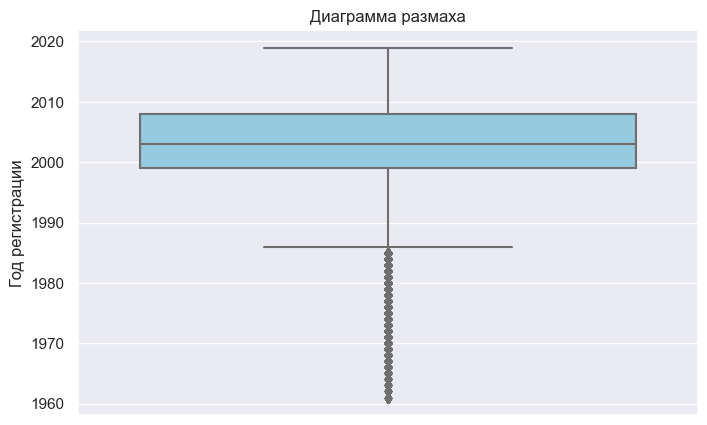

In [30]:
sns.set(style="darkgrid")
sns.boxplot(y=new_data['registration_year'], color='skyblue')
plt.title('Диаграмма размаха')
plt.ylabel('Год регистрации')

plt.show()

In [31]:
#проверим
pd.DataFrame(round(new_data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
price,3.000000
vehicle_type,10.000000
registration_year,0.000000
gearbox,5.000000
power,11.000000
kilometer,0.000000
fuel_type,9.000000
brand,0.000000
repaired,20.000000


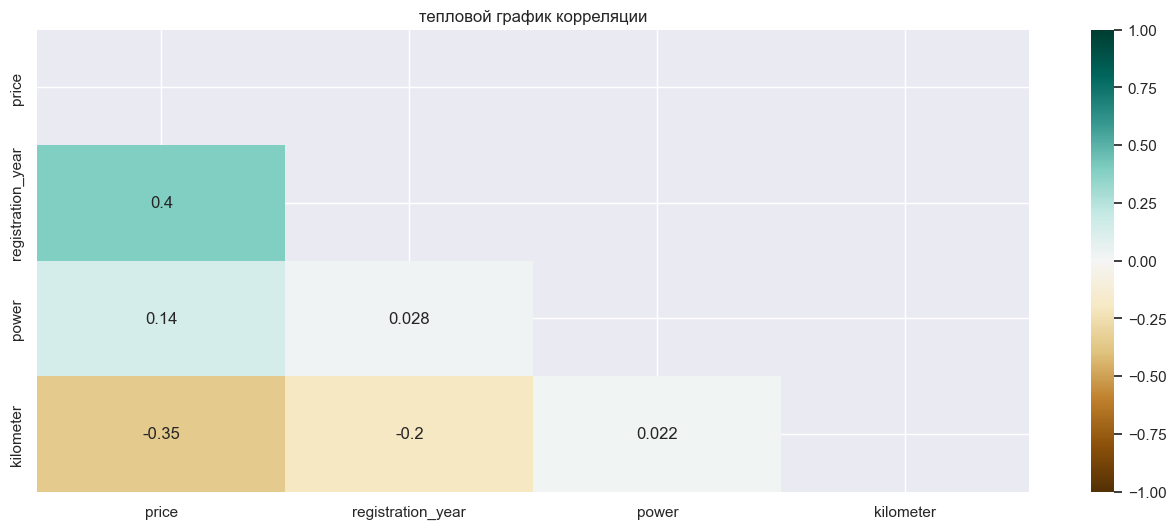

In [33]:
#построим тепловой график корреляции столбцов 
plt.figure(figsize=(16, 6)) 
mask = np.triu(np.ones_like(new_data.corr(numeric_only=True), dtype=bool)) 
heatmap = sns.heatmap(new_data.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('тепловой график корреляции');

неожиданно, на цены автомобиля у нас прослеживается прямая зависимость с годом регистрации и мощностью автомобиля...

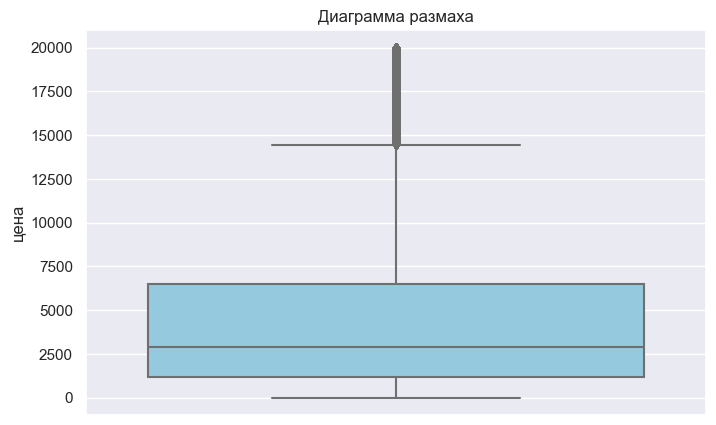

In [33]:
sns.set(style="darkgrid")
sns.boxplot(y=new_data['price'], color='skyblue')
plt.title('Диаграмма размаха')
plt.ylabel('цена')

plt.show()

In [34]:
new_data['price'].value_counts().sort_index()

price
1.0        1156
2.0          11
3.0           8
4.0           1
5.0          26
           ... 
19995.0      10
19997.0       1
19998.0       6
19999.0     278
20000.0     262
Name: count, Length: 3730, dtype: int64

In [35]:
new_data['price'].quantile(0.01)

100.0

Мы оставили данные с 1960 по 2020 год. В стобце `price` мы видим низкие значения 1-100 евро. Единичный квантиль в столбце `price` равно 100. Предлагаю удалить все что ниже этой цены

In [36]:
new_data = new_data.query('price >= 100')

In [37]:
new_data.shape

(340559, 9)

In [38]:
#проверим пропуски
pd.DataFrame(round(new_data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,10.000000
registration_year,0.000000
gearbox,5.000000
power,10.000000
kilometer,0.000000
fuel_type,8.000000
brand,0.000000
repaired,19.000000


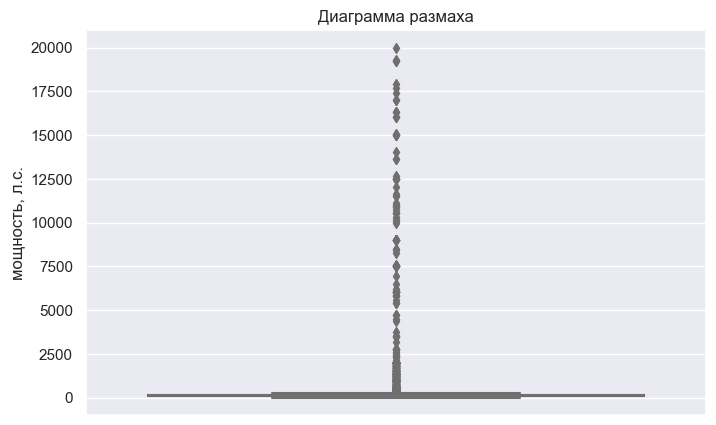

In [39]:
sns.set(style="darkgrid")
sns.boxplot(y=new_data['power'], color='skyblue')
plt.title('Диаграмма размаха')
plt.ylabel('мощность, л.с.')

plt.show()

Самый мощный на сегодняшний день легковой автомобиль способен выдать запредельные 4515 л.с.. Посмотрим сколько значений выше этого порога, а потом безжалостно удалим этих обманщиков. 

In [40]:
new_data.query('power >= 4500')

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
7661,1499.0,small,1999,manual,7515.0,150000,petrol,volkswagen,NaN
25232,10900.0,bus,2009,manual,10520.0,150000,gasoline,volkswagen,no
33952,3740.0,small,2006,manual,6920.0,90000,NaN,toyota,no
44520,2500.0,convertible,1998,manual,7512.0,150000,NaN,volkswagen,NaN
45053,15800.0,convertible,2014,auto,10218.0,30000,petrol,smart,NaN
...,...,...,...,...,...,...,...,...,...
339642,600.0,sedan,2000,manual,10110.0,125000,petrol,ford,NaN
341066,449.0,NaN,2016,manual,4507.0,150000,petrol,opel,no
341320,1899.0,other,2006,manual,7518.0,125000,petrol,citroen,yes
346639,1300.0,sedan,2000,manual,12512.0,150000,petrol,mitsubishi,NaN


Славно. их не так много, значит будет не так грустно с ними прощаться

In [41]:
new_data = new_data.query('power <= 4500')

In [42]:
new_data.shape

(305673, 9)

In [43]:
#Заполним пропуски в столбце power методом KNNImputer из библиотеки sklearn
knn = KNNImputer()
power = knn.fit_transform(new_data[['power']])
new_data['power'] = power

In [44]:
#проверим пропуски
pd.DataFrame(round(new_data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,7.000000
registration_year,0.000000
gearbox,2.000000
power,0.000000
kilometer,0.000000
fuel_type,6.000000
brand,0.000000
repaired,15.000000


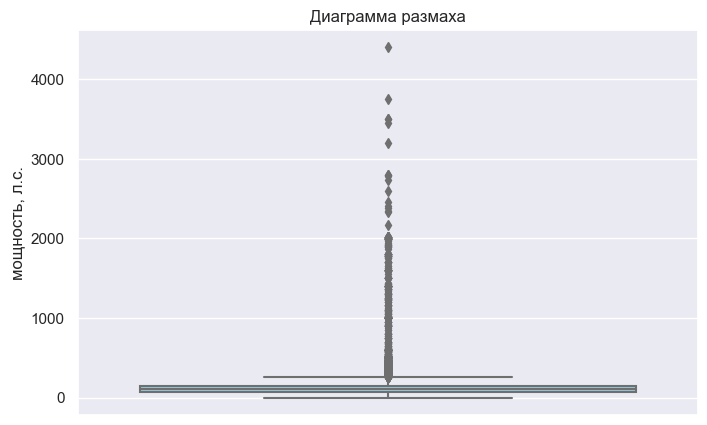

In [45]:
sns.set(style="darkgrid")
sns.boxplot(y=new_data['power'], color='skyblue')
plt.title('Диаграмма размаха')
plt.ylabel('мощность, л.с.')

plt.show()

In [46]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305673 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              305673 non-null  float64
 1   vehicle_type       284610 non-null  object 
 2   registration_year  305673 non-null  int64  
 3   gearbox            299729 non-null  object 
 4   power              305673 non-null  float64
 5   kilometer          305673 non-null  int64  
 6   fuel_type          286164 non-null  object 
 7   brand              305673 non-null  object 
 8   repaired           259062 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 23.3+ MB


В столбцах `vehicle_type`, `gearbox`, `fuel_type`, `repaired` пропуски заполним заглушкой `unknown`. Есть наитие, что это самый лучший вариант

In [47]:
pd.DataFrame(round(new_data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,7.000000
registration_year,0.000000
gearbox,2.000000
power,0.000000
kilometer,0.000000
fuel_type,6.000000
brand,0.000000
repaired,15.000000


In [48]:
new_data = new_data.fillna('unkmown')

In [49]:
#проверим пропуски
pd.DataFrame(round(new_data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
kilometer,0.000000
fuel_type,0.000000
brand,0.000000
repaired,0.000000


In [50]:
new_data.shape

(305673, 9)

**как красиво!**

вывод:
Из таблицы с размером (354369, 16) мы получили таблицу (305673, 9).
- удалили столбцы: `number_of_pictures`, `postal_code`, `date_crawled`, `date_created`, `last_seen`, `model`, `registration_month`;
- оставили автомобили выпуска с 1960 по 2020 года;
- в столбцах `price`,`power` заменили нули на nan и обработали как пропуски;
- вычислили единичный квантиль в толбце `price`. а все что ниже этой суммы удалили, чтобы избавиться от шумов;
- удалили значения выше 4500 в столбце `power`;
- В столбцах `vehicle_type`, `gearbox`, `fuel_type`, `repaired` пропуски заполним заглушкой `unknown`

## Обучение моделей

In [51]:
#разделим выборки на тренировочную, ввлидационную и тестовую в соотношении 6:2:2
features = new_data.drop(['price'], axis=1)
target = new_data['price']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345
)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345
)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(183403, 8)
(61135, 8)
(61135, 8)


Напишем функцию oneHotEncode для кодирования наших выборок.

In [52]:
def oneHotEncode(df):
    # инициализируем кодировщик
    ohe = OneHotEncoder()

    # получаем список незакодированных признаков
    non_encoded_columns = [col for col in df.columns if df[col].dtype == 'object']

    # кодируем незакодированные признаки
    encoded_columns = ohe.fit_transform(df[non_encoded_columns]).toarray()

    # сохраняем имена кодированных признаков
    encoded_columns_names = ohe.get_feature_names(non_encoded_columns)

    # сохраняем имена исходных незакодированных признаков
    non_encoded_columns_names = df[non_encoded_columns].columns.values

    # удаляем незакодированные признаки
    df.drop(non_encoded_columns, axis=1, inplace=True)

    # добавляем кодированные признаки
    for col, name in zip(encoded_columns.T, encoded_columns_names):
        df[name] = col

    return df

In [53]:
features_train_ohe = features_train.copy()
oneHotEncode(features_train_ohe)

,registration_year,power,kilometer,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_unkmown,repaired_yes
243574,2002,84.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
126172,2008,224.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
57784,2004,102.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
340790,1998,90.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
229766,2002,60.0,150000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184115,1998,75.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
55635,2001,286.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100253,2011,69.0,20000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
89742,1997,101.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
features_valid_ohe = features_valid.copy()
oneHotEncode(features_valid_ohe)

,registration_year,power,kilometer,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_unkmown,repaired_yes
222327,2003,136.0,90000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
176983,2006,170.0,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
153359,2004,140.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
282651,1996,220.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61751,2004,60.0,125000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338550,1996,68.0,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
107440,2000,75.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
33930,2005,121.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
217179,2009,170.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [55]:
features_test_ohe = features_valid.copy()
oneHotEncode(features_test_ohe)

,registration_year,power,kilometer,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_unkmown,repaired_yes
222327,2003,136.0,90000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
176983,2006,170.0,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
153359,2004,140.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
282651,1996,220.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61751,2004,60.0,125000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338550,1996,68.0,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
107440,2000,75.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
33930,2005,121.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
217179,2009,170.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [56]:
print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

(183403, 66)
(61135, 66)
(61135, 66)


### Линейная регрессия

In [57]:
%%time
model_lg = LinearRegression()
model_lg.fit(features_train_ohe, target_train)


CPU times: total: 828 ms
Wall time: 475 ms


LinearRegression()

In [58]:
%%time
predicted_valid_lg = model_lg.predict(features_valid_ohe)
print('RMSE для логистической регрессии =', (mean_squared_error(target_valid, predicted_valid_lg))**.5)


RMSE для логистической регрессии = 2850.8576284098294
CPU times: total: 0 ns
Wall time: 23 ms


### Случайный лес


In [59]:
# порядковое кодирование
encoder = OrdinalEncoder()
cat_columns = ['gearbox', 'vehicle_type', 'fuel_type', 'brand', 'repaired']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])


Подберем лучшие гиперпараметры для нашей модели.

In [60]:
%%time
model_rf = make_pipeline(RandomForestRegressor())
params_rf = {"randomforestregressor__n_estimators":[5,100],
             "randomforestregressor__max_depth":[1,100]}
grid_rf = GridSearchCV(model_rf, param_grid = params_rf, scoring='neg_mean_squared_error')
grid_rf.fit(features_train_ord, target_train)




CPU times: total: 4min 23s
Wall time: 4min 24s


GridSearchCV(estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [1, 100],
                         'randomforestregressor__n_estimators': [5, 100]},
             scoring='neg_mean_squared_error')

In [61]:
print("Лучшие модели")
print(grid_rf.best_estimator_)

Лучшие модели
Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=100))])


In [62]:
print('RMSE для случайного леса =', (grid_rf.best_score_.mean() * -1) ** .5)

RMSE для случайного леса = 1673.3415713565973


*измерим время обучения и скорость предсказания на лучших гиперпараметрах*

In [63]:
%%time
model_rf2 = RandomForestRegressor(random_state=12345, max_depth=100)
model_rf2.fit(features_train_ord, target_train)

CPU times: total: 45.2 s
Wall time: 45.5 s


RandomForestRegressor(max_depth=100, random_state=12345)

In [64]:
%%time
predictions_valid = model_rf2.predict(features_valid_ord)
result = mean_squared_error(target_valid, predictions_valid) ** .5
print('RMSE для случайного леса на валидационной выборке =', result)

RMSE для случайного леса на валидационной выборке = 1685.471643558462
CPU times: total: 2.48 s
Wall time: 2.5 s


### Градиентный бустинг CatBoost


In [65]:
%%time
model_cat = CatBoostRegressor()
params_cat = [{'learning_rate':[0.1, 0.5, 0.8],
         'random_state':[12345],
         'verbose':[False]}]
grid_cat = GridSearchCV(model_cat, params_cat, scoring='neg_mean_squared_error')
grid_cat.fit(features_train_ord, target_train)



CPU times: total: 3min 1s
Wall time: 3min 36s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x0000023F887714D0>,
             param_grid=[{'learning_rate': [0.1, 0.5, 0.8],
                          'random_state': [12345], 'verbose': [False]}],
             scoring='neg_mean_squared_error')

In [66]:
print("Лучшие модели")
print(grid_cat.best_params_)

Лучшие модели
{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}


In [67]:
print('RMSE для случайного леса =', (grid_cat.best_score_.mean() * -1) ** .5)

RMSE для случайного леса = 1631.1665142605952


*измерим время обучения и скорость предсказания на лучших гиперпараметрах*

In [68]:
%%time
model_cat2 = CatBoostRegressor(learning_rate=0.5, random_state=12345, verbose=False, cat_features=cat_columns)
model_cat2.fit(features_train, target_train)

CPU times: total: 1min 54s
Wall time: 1min 38s


In [69]:
%%time
predictions_valid = model_cat2.predict(features_valid)
result = mean_squared_error(target_valid, predictions_valid) ** .5
print('RMSE для CatBoost на валидационной выборке =', result)

RMSE для CatBoost на валидационной выборке = 1652.427488381316
CPU times: total: 1.11 s
Wall time: 217 ms


### Градиентный бустинг LightGBM

In [70]:
%%time
model_lgbm = LGBMRegressor()
params_lgbm = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[123450]}]

grid_lgbm = GridSearchCV(model_lgbm, params_lgbm, scoring='neg_mean_squared_error')
grid_lgbm.fit(features_train_ord, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 146722, number of used features: 8
[LightGBM] [Info] Start training from score 4821.106426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 146722, number of used features: 8
[LightGBM] [Info] Start training from score 4824.910886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

GridSearchCV(estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.3], 'num_leaves': [11, 50, 100],
                          'random_state': [123450]}],
             scoring='neg_mean_squared_error')

In [71]:
print("Лучшие модели")
print(grid_lgbm.best_params_)

Лучшие модели
{'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 123450}


In [72]:
print('RMSE для LightGBM =', (grid_lgbm.best_score_.mean() * -1) ** .5)

RMSE для LightGBM = 1626.6783492350949


*измерим время обучения и скорость предсказания на лучших гиперпараметрах*

In [77]:
%%time
model_lgbm2 = LGBMRegressor(learning_rate=0.3, random_state=123450, num_leaves=100)
model_lgbm2.fit(features_train_ord, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 183403, number of used features: 8
[LightGBM] [Info] Start training from score 4824.793231
CPU times: total: 4.05 s
Wall time: 610 ms


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=123450)

In [78]:
%%time
predictions_valid = model_lgbm2.predict(features_valid_ord)
result = mean_squared_error(target_valid, predictions_valid) ** .5
print('RMSE для LightGBM на валидационной выборке =', result)

RMSE для LightGBM на валидационной выборке = 1644.7627008459194
CPU times: total: 484 ms
Wall time: 71.6 ms


## Анализ моделей

В ходе исслелования мы обучили несколько моделей:
- Линейная регрессия
- Дерево решений 
- Градиентный бустинг CatBoost 
- Градиентный бустинг LightGBM

Давайте, построим таблицу, чтобы нам легче было визуализировать результаты


In [79]:
results_df = pd.DataFrame(
    {
        'модель': ['Линейная Регрессия', 'Случайный лес', 'Градиентный бустинг CatBoost', 'Градиентный бустинг LightGBM'], 
        'время обучения': ['4.05s', '46.9 s', '3min 18s', '6.41 s'],
        'скорость предсказания': ['15.3 ms', '2.83 s', '748 ms', '1.04 s'],
        'rmse на валидационной выборки':[2850, 1685, 1652, 1644]
    })

In [80]:
results_df

,модель,время обучения,скорость предсказания,rmse на валидационной выборки
0,Линейная Регрессия,4.05s,15.3 ms,2850
1,Случайный лес,46.9 s,2.83 s,1685
2,Градиентный бустинг CatBoost,3min 18s,748 ms,1652
3,Градиентный бустинг LightGBM,6.41 s,1.04 s,1644


## Тестирование лучшей модели

По итогам анализа, лучшей моделью мы выбрали Случайный лес. 
модель на тестовой выборке

In [81]:
%%time
model_rf3 = RandomForestRegressor(random_state=12345, max_depth=100)
model_rf3.fit(features_train_ord, target_train)

CPU times: total: 48.2 s
Wall time: 48.5 s


RandomForestRegressor(max_depth=100, random_state=12345)

In [82]:
%%time
predictions_valid = model_rf3.predict(features_test_ord)
result = mean_squared_error(target_test, predictions_valid) ** .5
print('RMSE для случайного леса на тестовой выборке =', result)

RMSE для случайного леса на тестовой выборке = 1639.2069619402916
CPU times: total: 3.23 s
Wall time: 3.24 s
